# Neural Style Transfer

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pprint
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchinfo import summary

%matplotlib inline

## Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

We will be using the eponymously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [3]:
torch.manual_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400

vgg = models.vgg19(pretrained=True).features

D:\github\machine-learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\github\machine-learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\izhar/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:34<00:00, 6.08MB/s] 


In [4]:
# freeze model parameters
for param in vgg.parameters():
    param.requires_grad = False

pp.pprint(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Neural Style Transfer (NST)

Build the Neural Style Transfer (NST) algorithm in three steps:

- First, build the content cost function $J_{content}(C,G)$
- Second, build the style cost function $J_{style}(S,G)$
- Finally, put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$

### Computing the Content Cost Function $J_{content}(C,G)$
One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when we do need to carry out a similar operation later for computing the style cost $J_{style}$.

In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    content_output -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image C
    generated_output -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # We assume the input tensors are in the format (N, C, H, W) for PyTorch
    a_C = content_output
    a_G = generated_output
    
    # Compute the content cost
    _, C, H, W = a_G.size()
    J_content = 1 / (4 * C * H * W) * torch.sum((a_C - a_G) ** 2)
    
    return J_content

### Computing the Style Cost

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, we would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 
* For the sake of clarity, $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.

#### Compute Gram matrix $G_{gram}$
We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose.

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [6]:
def gram_matrix(A):
    """
    Argument:
    A -- tensor of shape (C, H*W)
    Returns:
    GA -- Gram matrix of A, of shape (C, C)
    """
    GA = torch.mm(A, A.t())
    return GA

Minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, we will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.

In [7]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # PyTorch uses (N, C, H, W) so we don't need to transpose tensors as in TensorFlow
    _, C, H, W = a_G.size()
    
    # Reshape the tensors from (1, C, H, W) to (C, H*W) for PyTorch
    a_S = a_S.view(C, H * W)
    a_G = a_G.view(C, H * W)

    # Computing gram matrices for both images S and G using the previously defined PyTorch function
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = 1 / (4 * (C ** 2) * ((H * W) ** 2)) * torch.sum((GS - GG) ** 2)
        
    return J_style_layer

#### Style Weights

* So far we have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [23]:
from torch import nn

In [25]:
class VGGFeatures(nn.Module):
    def __init__(self, style_layers, content_layers):
        super(VGGFeatures, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features.to(device).eval()
        
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        self.style_layers = style_layers
        self.content_layers = content_layers
        # Trim the model to include layers up to the max index found in style and content layers
        self.model = nn.Sequential(*list(self.vgg.children())[:max(max(style_layers), max(content_layers)) + 1])

    def forward(self, x):
        style_features = []
        content_features = []
        
        for name, layer in enumerate(self.model):
            x = layer(x)
            if name in self.style_layers:
                style_features.append(x)
            if name in self.content_layers:
                content_features.append(x)
        
        return style_features, content_features

In [27]:
# Define the layers you want to extract features from
# Note that we are using the indices of the layers in PyTorch's VGG model
style_layers = [0, 5, 10, 19, 28]  # Corresponding to the 'conv1_1', 'conv2_1', etc.
content_layers = [21]  # 'conv4_2' in PyTorch's VGG19

vgg_features = VGGFeatures(style_layers, content_layers)

In [11]:
# style_layers = {
#     0: ('block1_conv1', 0.2),  # This is the first conv layer
#     5: ('block2_conv1', 0.2),  # First layer of the second block
#     10: ('block3_conv1', 0.2), # First layer of the third block
#     19: ('block4_conv1', 0.2), # First layer of the fourth block
#     28: ('block5_conv1', 0.2), # First layer of the fifth block
# }

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

In [79]:
def compute_style_cost(style_image_output, generated_image_output, style_layers_weights):
    """
    Computes the overall style cost from several chosen layers in PyTorch.

    Arguments:
    style_image_output -- list of PyTorch tensors, the outputs from the chosen layers of the VGG19 for the style image
    generated_image_output -- list of PyTorch tensors, the outputs from the chosen layers of the VGG19 
                                for the generated image
    style_layers_weights -- list of tuples, each containing the layer index and its corresponding weight in the 
                            style cost computation

    Returns: 
    J_style -- PyTorch tensor, scalar value representing the overall style cost
    """
    
    # Initialize the overall style cost
    J_style = 0
    
    for ((layer_name, weight), a_S, a_G) in zip(style_layers_weights, style_image_output, generated_image_output):
        # Compute style cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[0], a_G[0])

        # Add weighted J_style_layer of this layer to overall style cost
        J_style += weight * J_style_layer

    return J_style

### Defining the Total Cost to Optimize

Finally, we will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [13]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost function in PyTorch.
    
    Arguments:
    J_content -- content cost computed above
    J_style -- style cost computed above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style
    return J

## Solving the Optimization Problem

Finally, we get to put everything together to implement Neural Style Transfer!

Here's what our program be able to do:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

### 1. Load the Content and Style Images

In [14]:
# Set the device to run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the image size and transformation pipeline
img_size = 400
loader = transforms.Compose([
    transforms.Resize((img_size, img_size)), # Resize the image
    transforms.ToTensor(), # Convert to PyTorch tensor
])

In [15]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [16]:
content_image_path = "images/louvre_small.jpg"
style_image_path = "images/monet.jpg"

In [17]:
content_image = image_loader(content_image_path)
style_image = image_loader(style_image_path)

In [18]:
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

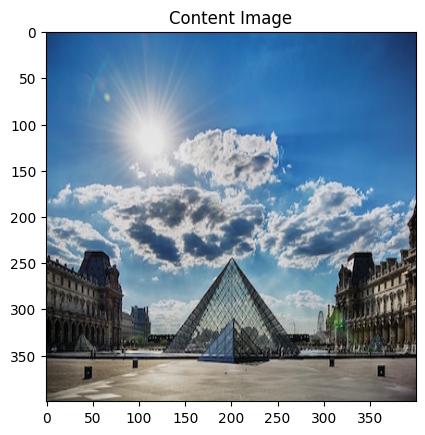

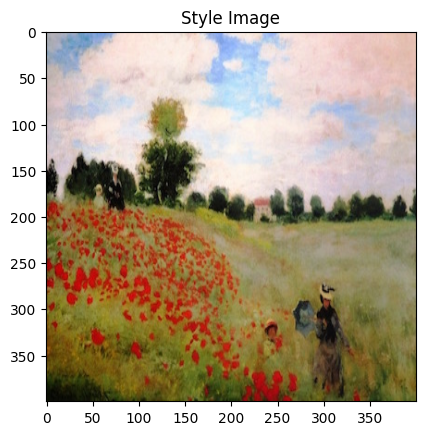

In [19]:
# Display content and style images
plt.figure()
imshow(content_image, title='Content Image')

plt.figure()
imshow(style_image, title='Style Image')

### 2. Randomly Initialize the Image to be Generated

In [20]:
# Generate a mixed image
generated_image = content_image.clone().requires_grad_(True)

In [21]:
# Adding noise
noise = torch.randn(generated_image.size()).to(device) * 0.25
generated_image = generated_image + noise
generated_image = torch.clamp(generated_image, 0, 1)  # Ensure the values are between 0 and 1

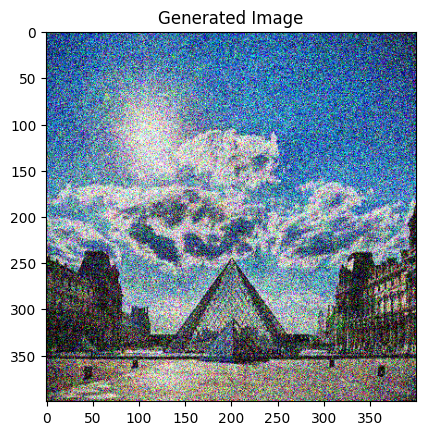

In [22]:
# Display generated image
plt.figure()
imshow(generated_image, title='Generated Image')

### 3. Load the Pre-trained VGG19 Model

In [73]:
# Define style weights separately, corresponding to the layer indices
# style_weights = {0: 0.2, 5: 0.2, 10: 0.2, 19: 0.2, 28: 0.2}
style_layers_weights = [('conv1_1', 0.2), ('conv2_1', 0.2), ('conv3_1', 0.2), ('conv4_1', 0.2), ('conv5_1', 0.2)]

### 4. Compute Total Cost

In [35]:
preprocess = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [75]:
# Convert images to PyTorch tensors and preprocess
content_tensor = preprocess(content_image).squeeze(0).to(device)
style_tensor = preprocess(style_image).squeeze(0).to(device)

In [41]:
# Create an instance of the modified VGG model
vgg_features = VGGFeatures(style_layers=[0, 5, 10, 19, 28], content_layers=[21]).to(device)

In [76]:
content_tensor.shape

torch.Size([3, 400, 400])

In [74]:
# Extract features
style_features = vgg_features(style_tensor)[0]  # Only style features
content_features = vgg_features(content_tensor)[1]  # Only content features

In [78]:
type(content_features)

1

In [44]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1 in PyTorch.
    Arguments:
        image -- Tensor
    Returns:
        Tensor
    """
    return torch.clamp(image, min=0.0, max=1.0)

In [45]:
def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image in PyTorch.
    Arguments:
        tensor -- Tensor
    Returns:
        Image: A PIL image
    """
    tensor = tensor.to("cpu").detach()
    tensor = tensor.numpy()
    tensor = np.squeeze(tensor)
    if tensor.ndim == 3:
        tensor = tensor.transpose(1, 2, 0)
    tensor = np.clip(tensor * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(tensor)

### 5. Train Step

In [49]:
# Assuming 'generated_image_initial' is your initial image tensor
generated_image = torch.nn.Parameter(generated_image.clone().detach().requires_grad_(True))

# Now define the optimizer with this `generated_image`
optimizer = torch.optim.Adam([generated_image], lr=0.01)

In [80]:
def train_step(generated_image, optimizer):
    optimizer.zero_grad()
    
    # Get the features for the generated image
    style_features_gen, content_features_gen = vgg_features(generated_image)
    
    # Assuming 'style_features' and 'content_features' are pre-computed for the style and content images
    J_style = compute_style_cost(style_features, style_features_gen, style_layers_weights)
    J_content = compute_content_cost(content_features, content_features_gen)
    J_total = total_cost(J_content, J_style, alpha=10, beta=40)
    
    J_total.backward()
    optimizer.step()
    
    # Clipping the values of the generated image to be between 0 and 1
    with torch.no_grad():
        generated_image.data.clamp_(0, 1)

    return J_total

In [63]:
# Function to convert a tensor to a PIL Image and display it
def tensor_to_image(tensor):
    # Convert the tensor to a range [0, 255]
    tensor = tensor.cpu().detach().numpy()  # Ensure it's on CPU and detached
    tensor = tensor.squeeze()  # Remove batch dimension if present
    tensor = tensor.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C) if necessary
    tensor = np.clip(tensor, 0, 1) * 255
    tensor = tensor.astype(np.uint8)
    return Image.fromarray(tensor)

### 6. Train the Model

In [81]:
# Training loop
epochs = 501
for i in range(epochs):
    J = train_step(generated_image, optimizer)
    if i % 250 == 0:
        print(f"Epoch {i}, Total Cost: {J.item()}")
        img = tensor_to_image(generated_image)
        plt.imshow(img)
        plt.title(f"Epoch {i}")
        plt.show()

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# Show the generated image at some epochs (VERY SLOW ON CPU)
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"images/image_{i}.jpg")
        plt.show() 

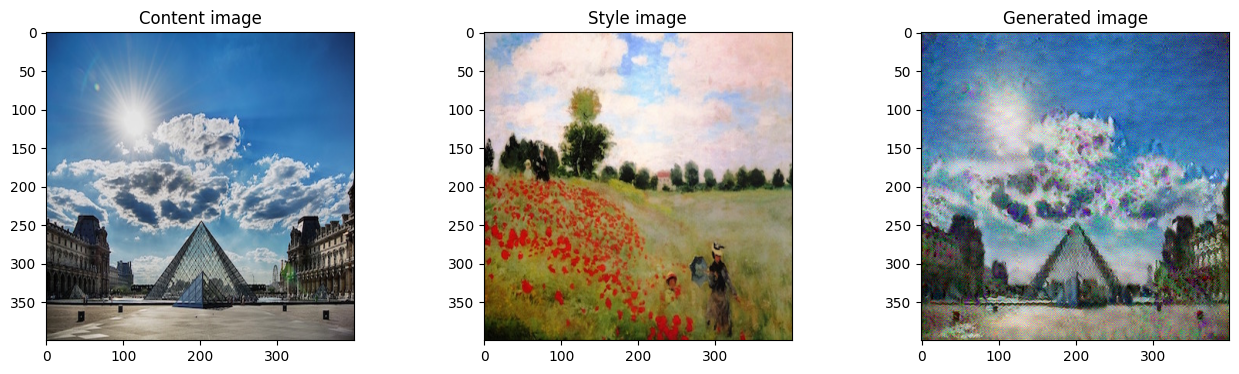

In [32]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

**Note 2:** The hyperparameters (`learning_rate=0.01` and `epochs = 2501`) were set to these values so that we didn't have to wait too long to see an initial result. To get the best looking results, we may want to try running the optimization algorithm longer (and perhaps with a smaller learning rate). Running for around `epochs = 20000` with a `learning_rate=0.001`, we should see something like the image presented below.

<img src="images/louvre_generated.png" style="width:800px;">

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;">